### Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import re
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *


# Load Data

In [2]:
#load Data
PATH_TRAIN_POS = 'twitter-datasets/train_pos.txt'
PATH_TRAIN_NEG = 'twitter-datasets/train_neg.txt'

pos_train = pd.read_csv(PATH_TRAIN_POS, sep = '\r',  names = ['Text'])
pos_train.insert(1, 'Target', 1)


neg_train = pd.read_csv(PATH_TRAIN_NEG, sep = '\r',  names = ['Text'])
neg_train.insert(1, 'Target', -1)

#pos_train.head()
#neg_train.head()
print('length of data is', len(pos_train))
print('length of data is', len(neg_train))

pos_train = pos_train.iloc[:2000]
neg_train = neg_train.iloc[:2000]
print('length of subdata is', len(pos_train))
print('length of subdata is', len(neg_train))

length of data is 97902
length of data is 99068
length of subdata is 2000
length of subdata is 2000


In [3]:
pos_train.head()

,Text,Target
0,<user> i dunno justin read my mention or not ....,1
1,"because your logic is so dumb , i won't even c...",1
2,<user> just put casper in a box ! looved the...,1
3,<user> <user> thanks sir > > don't trip lil ma...,1
4,visiting my brother tmr is the bestest birthda...,1


In [4]:
neg_train.head()

,Text,Target
0,vinco tresorpack 6 ( difficulty 10 of 10 objec...,-1
1,glad i dot have taks tomorrow ! ! #thankful #s...,-1
2,1-3 vs celtics in the regular season = were fu...,-1
3,<user> i could actually kill that girl i'm so ...,-1
4,<user> <user> <user> i find that very hard to ...,-1


In [5]:
#Drop Duplicates

pos_train.drop_duplicates(inplace=True)
neg_train.drop_duplicates(inplace=True)
print('length of data is', len(pos_train))
print('length of data is', len(neg_train))

length of data is 1846
length of data is 1820


In [6]:
# Get number of overall words 
pos_train_list = pos_train["Text"].tolist()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(pos_train_list)
features= vectorizer.get_feature_names()
print(len(features))


4264


# Split Data

In [15]:
#Merge Pos and Neg => Create Train_set
train_set= pd.concat([pos_train, neg_train])

X=  train_set.Text
y= train_set.Target

#SPLIT: Set same random_state to reproduce same result
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=13)

print("Train_set Info: SIZE= {size}, POSITIVE Tweets ={pos:0.2f}%, NEGATIVE Tweets = {neg:0.2f}%".format( size= len(X_train),
                                                                       pos = len(y_train[y_train == 1])*100/len(X_train),
                                                                       neg = len(y_train[y_train == -1])*100/len(X_train)))

print("Test_set Info: SIZE= {size}, POSITIVE Tweets ={pos:0.2f}%, NEGATIVE Tweets = {neg:0.2f}%".format( size= len(X_test),
                                                                       pos = len(y_test[y_test == 1])*100/len(X_test),
                                                                       neg = len(y_test[y_test == -1])*100/len(X_test)))
    
print(type(X))

Train_set Info: SIZE= 28008, POSITIVE Tweets =47.50%, NEGATIVE Tweets = 52.50%
Test_set Info: SIZE= 7002, POSITIVE Tweets =48.47%, NEGATIVE Tweets = 51.53%
<class 'pandas.core.series.Series'>


In [8]:
def evaluate_model(model,X_test ,y_pred, y_test) :
    
    #Show report
    print(classification_report(y_test, y_pred))
    
    #Show Confusion Matrix
    c_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(c_matrix, annot = labels, fmt = '',  xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.show() 
    
    
    ##Show ROC
    # generate a no skill prediction 
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    model_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    model_probs = model_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    model_auc = roc_auc_score(y_test, model_probs)
    # summarize scores

    #print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (model_auc))
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(model_fpr, model_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()    


# 1.NaiveBayesClassifier From nltk

Useful Documentation:

https://www.nltk.org/_modules/nltk/sentiment/sentiment_analyzer.html 

https://www.nltk.org/_modules/nltk/classify/naivebayes.html

In [134]:
#Create (tweet, target) pairs
tr_set= pd.concat([X_train,y_train], axis=1)
ts_set = pd.concat([X_test,y_test], axis=1)

#From pandas.DataFrame, to ndarray, to list of (tweet, target)
tr_set = tr_set.values.tolist()
ts_set = ts_set.values.tolist()

#WordTokenize the text of the tweet i.e. "Hello world!" becomes ['Hello', 'world','!'] "
tr_set= [(word_tokenize(tweet),target) for (tweet,target) in tr_set]
test_set = [(word_tokenize(tweet),target) for (tweet,target) in ts_set]

#Sentiment Analyzer
sentim_analyzer = SentimentAnalyzer()
#"all_words()" takes (list(str), str) as parameter
# returns: A list of all words/tokens in teh given (list(str))
all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in tr_set]) #tr_set must be tokenized
print("Number of  words, repetition allowed:",len(all_words_neg))
#returns: Return most common top_n word features
unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg)
#Add as a feature. for our data
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

#Apply feature to train set
tr_set_featured = sentim_analyzer.apply_features(tr_set)


Number of  words, repetition allowed: 231060


In [138]:
#training_set_featured

In [97]:
# TRAIN CLASSIFIER
trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set_featured )

Training classifier


In [111]:
# Process TEST SET
test_set_featured = sentim_analyzer.apply_features(ts_set)

In [114]:
sentim_analyzer.evaluate(test_set_featured )

Evaluating NaiveBayesClassifier results...


{'Accuracy': 0.7035714285714286,
 'Precision [1]': 0.6262476894639556,
 'Recall [1]': 0.8786307053941909,
 'F-measure [1]': 0.7312756313403841,
 'Precision [-1]': 0.8434782608695652,
 'Recall [-1]': 0.5550176056338029,
 'F-measure [-1]': 0.6694982744889832}

In [140]:
#version 2
# Using nltk.NaiveBayesClassifier : will give same result
classifier_bis = nltk.NaiveBayesClassifier.train(training_set_featured)
print(nltk.classify.accuracy(classifier_bis, test_set_featured) * 100)

70.35714285714286


# 2.NaiveBayes with Sklearn

### 2.1. With CountVectorizer Transformation

In [16]:
count_vect = CountVectorizer(max_features=10000,ngram_range=(1, 2))
X_train_count_matrix = count_vect.fit_transform(X_train)

print('Overall number of different words',len(count_vect.get_feature_names()))

X_test_count_matrix = count_vect.transform(X_test)

MNB_classifier = MultinomialNB().fit(X_train_count_matrix, y_train)

y_pred = MNB_classifier.predict(X_test_count_matrix)

#y_prob_predicted = clf.predict_proba(x_validation_counts)
#print("Accuracy : ", accuracy_score(y_test, y_pred))
print("{:.2f}".format(accuracy_score(y_test, y_pred)))
# Acc :0.74

evaluate_model(MNB_classifier,  X_test_count_matrix, y_pred,y_test)

Overall number of different words 10000
0.75


NameError: name 'evaluate_model' is not defined

### 2.2. With TF-IDF Transformation

In [9]:
#Convert a collection of raw documents to a matrix of TF-IDF features.
#Equivalent to CountVectorizer followed by TfidfTransformer.
#YOU ONLY FIT on train set -> get feature words
TFID_vect = TfidfVectorizer(max_features=100000,ngram_range=(1,2))

#Transform the data using TF-IDF Vectorizer
X_train_TFIDF_Matrix = TFID_vect.fit_transform(X_train)
X_test_TFIDF_Matrix  = TFID_vect.transform(X_test)

print('Number of feature words: ', len(TFID_vect.get_feature_names()))
print('X_test shape: ', X_test_TFIDF_Matrix.shape)

# get the first vector out (for the first document = tweet) i.e. first line of matrix
first_vector_tfidfvectorizer=X_train_TFIDF_Matrix[0] 

# place tf-idf values in a pandas data frame 
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=TFID_vect.get_feature_names(), columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)



Number of feature words:  100000
X_test shape:  (7002, 100000)


,tfidf
tweet its,0.358634
you hahaha,0.348461
user check,0.323949
last tweet,0.316058
check out,0.288177
...,...
of wouldn,0.000000
of world,0.000000
of working,0.000000
of work,0.000000


              precision    recall  f1-score   support

          -1       0.74      0.83      0.78      2272
           1       0.77      0.65      0.71      1928

    accuracy                           0.75      4200
   macro avg       0.75      0.74      0.74      4200
weighted avg       0.75      0.75      0.75      4200



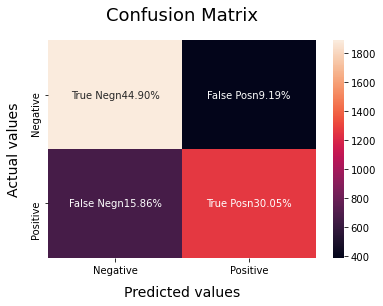

Model: ROC AUC=0.849


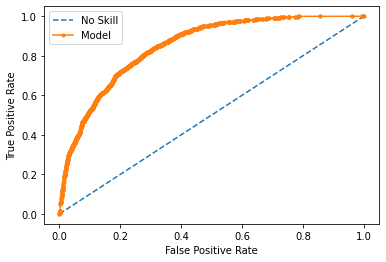

In [230]:
MNB_classifier = MultinomialNB().fit(X_train_TFIDF_Matrix, y_train)
y_pred = MNB_classifier.predict(X_test_TFIDF_Matrix)



evaluate_model(MNB_classifier,  X_test_TFIDF_Matrix, y_pred,y_test)



# 3.Logistic Regression with Sklearn

              precision    recall  f1-score   support

          -1       0.78      0.78      0.78      2272
           1       0.74      0.75      0.74      1928

    accuracy                           0.76      4200
   macro avg       0.76      0.76      0.76      4200
weighted avg       0.76      0.76      0.76      4200



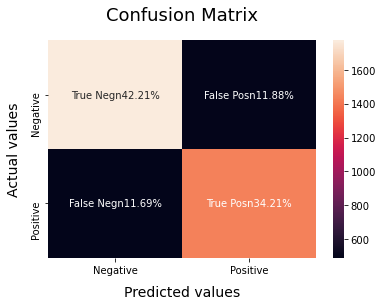

Model: ROC AUC=0.846


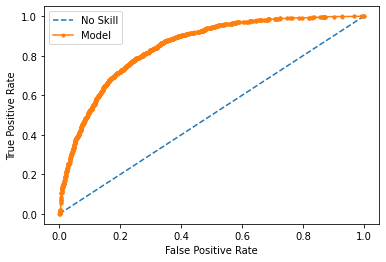

In [233]:
clf = LogisticRegression().fit( X_train_TFIDF_Matrix, y_train)
y_pred = clf.predict( X_test_TFIDF_Matrix)
evaluate_model(clf,  X_test_TFIDF_Matrix, y_pred,y_test)

              precision    recall  f1-score   support

          -1       0.78      0.78      0.78      2272
           1       0.75      0.75      0.75      1928

    accuracy                           0.77      4200
   macro avg       0.76      0.76      0.76      4200
weighted avg       0.77      0.77      0.77      4200



/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


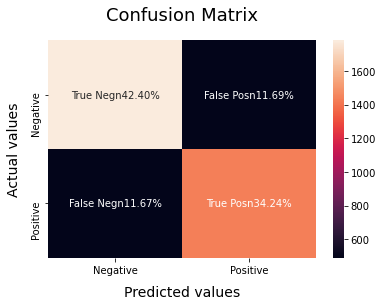

Model: ROC AUC=0.845


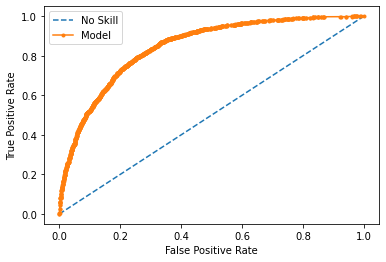

In [247]:
clf = LogisticRegression().fit( X_train_count_matrix, y_train)
y_pred = clf.predict( X_test_count_matrix)
evaluate_model(clf,  X_test_count_matrix, y_pred,y_test)

# 4.SVM with Sklearn

              precision    recall  f1-score   support

          -1       0.80      0.78      0.79      3608
           1       0.77      0.79      0.78      3394

    accuracy                           0.79      7002
   macro avg       0.79      0.79      0.79      7002
weighted avg       0.79      0.79      0.79      7002



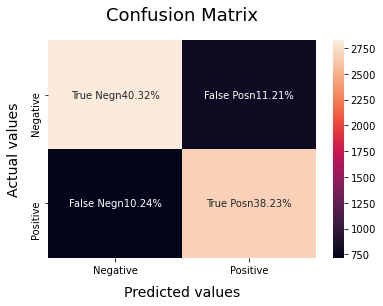

AttributeError: predict_proba is not available when  probability=False

In [10]:

clf = svm.SVC()
clf.fit( X_train_TFIDF_Matrix, y_train)
y_pred = clf.predict( X_test_TFIDF_Matrix)
evaluate_model(clf,  X_test_TFIDF_Matrix, y_pred,y_test)
#Acc = 0.77  and with a larger data set got Acc=0.79
#AUC=0.849 